# Using netgraph for visualization

Import annotations.

In [96]:
import polars as pl

df = pl.read_parquet('../../dgym-data/experiment_annotations.parquet')
tested_adjacency = df[['Inspiration', 'SMILES']]
tested_adjacency = tested_adjacency.drop_nulls().to_numpy()

Create partitions.

In [97]:
import igraph as ig

# Make graph
g = ig.Graph.TupleList(tested_adjacency, directed=True)

# Remove self-loops
g = g.simplify()

# Filter Tested molecules
vertices_to_include = set()
tested_smiles = df.filter(pl.col("Current Status") == "Tested")['SMILES']
for tested_smiles_ in tested_smiles[::4]:
    subcomponent = g.subcomponent(tested_smiles_, mode="IN")
    vertices_to_include.update(subcomponent)

g = g.subgraph(vertices_to_include)

Make colors based on utility.

In [111]:
# scores = df[list(vertices_to_include), 'utility']
scores = [df.filter(pl.col('SMILES') == v)['utility'][0] for v in vertices]

# Step 2: Customize vertex colors and outlines
import seaborn as sns
palette = sns.color_palette("magma", as_cmap=True)
vertex_colors = [palette(score) for score in scores]
vertex_frame_colors = ['white'] * len(vertex_colors)
vertex_frame_width = [1.0] * len(vertex_colors)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


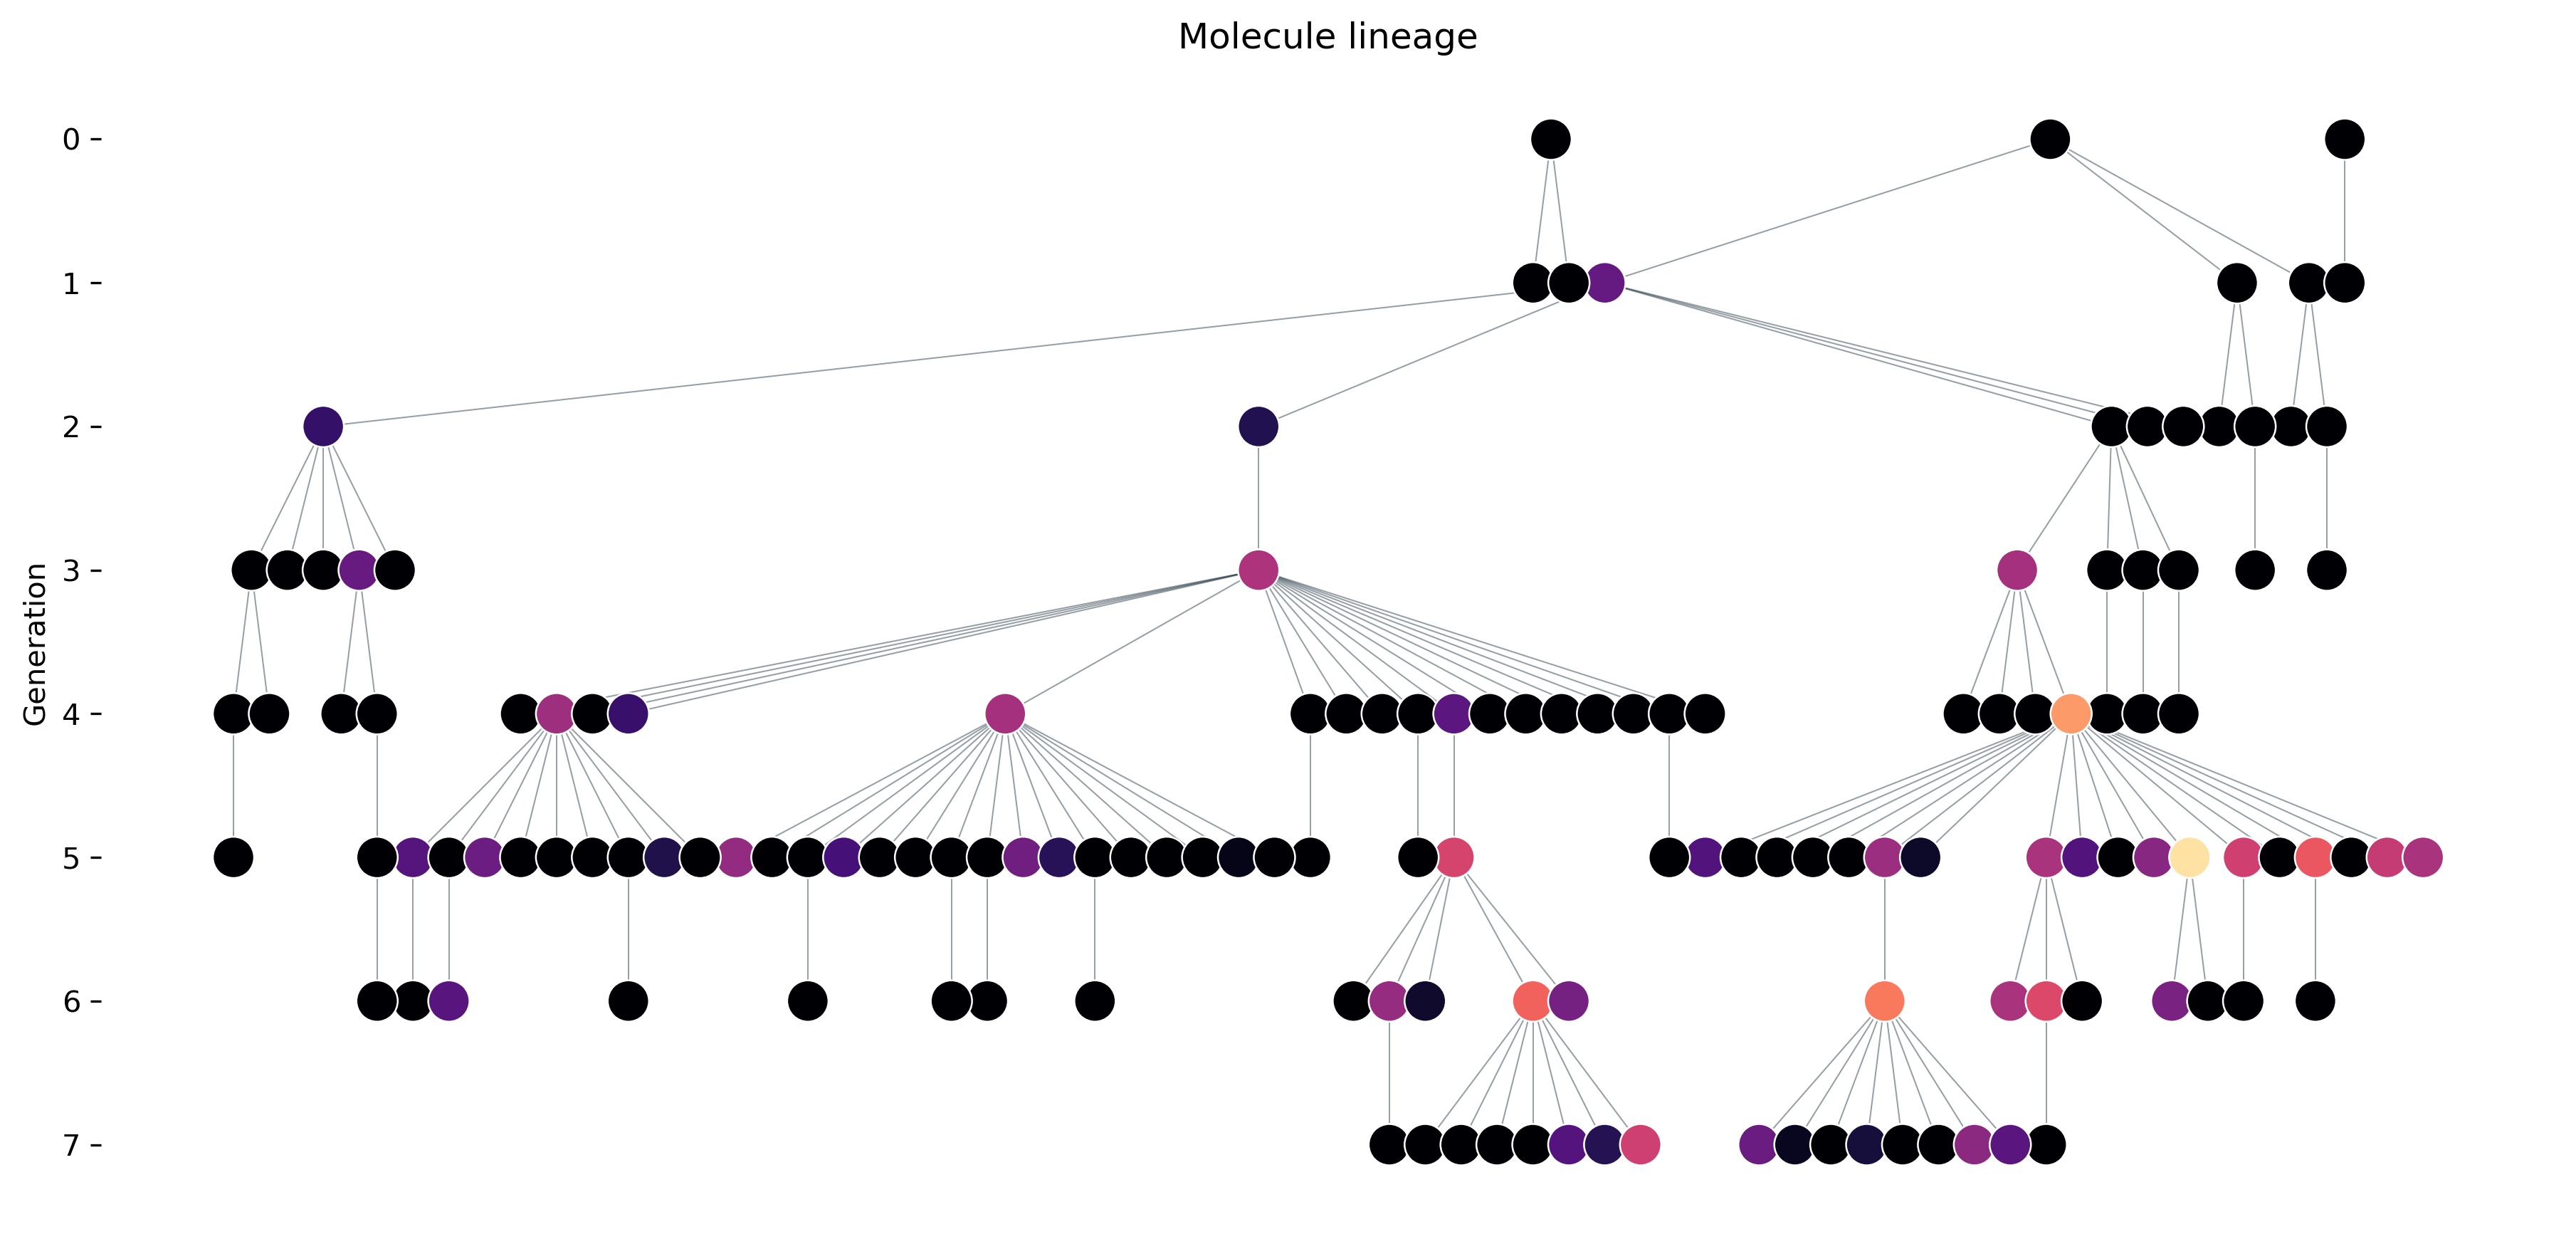

In [112]:
import numpy as np
from netgraph import Graph
import matplotlib.pyplot as plt

coords = g.layout("rt")
x, y = zip(*coords.coords)
x = np.array([x_ / 20 for x_ in x])
y = np.array([y_ / -5 for y_ in y])
vertices = g.get_vertex_dataframe()['name'].tolist()
coord_dict = {i: (x[i], y[i]) for i, _ in enumerate(vertices)}
color_dict = {i: vertex_colors[i] for i, _ in enumerate(vertices)}

fig, ax = plt.subplots(figsize=(15, 7), dpi=300)
Graph(
    g,
    node_layout=coord_dict,
    edge_width=0.20,
    node_color=color_dict,
    node_edge_color='white',
    node_edge_width=0.25,
    ax=ax
)

unique_y_ticks = np.unique(y)
ax.set_yticks(unique_y_ticks)
ax.set_yticklabels(reversed(range(len(unique_y_ticks))))
ax.set_ylabel('Generation')
ax.set_title('Molecule lineage')

plt.show()